In [428]:
import os,sys,inspect
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0,parentdir) 

import matplotlib.pyplot as plt
from BasicSetupUtilities.MetaDataBuilder import CountryMetaDataFile
from DataIOUtilities.DataLib import DataLib, DatastreamPulls
import pandas as pd
import numpy as np

#### Initialization

In [429]:
WEEKDAYS_IN_YEAR = 261
DAYS_IN_MONTH = 20

dl = DataLib("SignalData")
BondReturnIdx = dl.pull("BondRetIdx/LocalFX")
fxvsusd = dl.pull("fxVsUSD")
equities = dl.pull("EquityPrices")
m1 = dl.pull("M1/inUSD")
m2 = dl.pull("M2/inUSD")
m3 = dl.pull("M3/inUSD")
curr_acct_nom = dl.pull("CurrAcctNom/inUSD")
curr_acct_gdp = dl.pull("CurrAcctPctGDP")
LongRates = dl.pull("LongRates")
ShortRates = dl.pull("ShortRates")
fxNominal = dl.pull("fxTrdWts/Nominal")
fxReal = dl.pull("fxTrdWts/Real")
core_cpi = dl.pull("CoreCPI/SA")
gdp_real = dl.pull("GDP/Real")

## Signal - Monetary Base

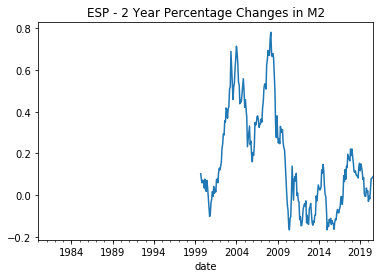

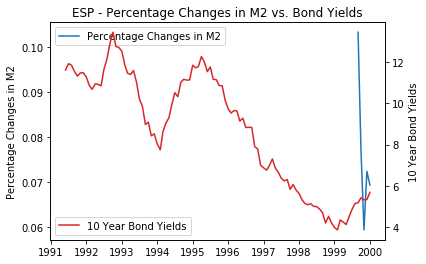

At 1990, the money supply is technically growing but we see that interest rates are falling. The relationship doesn't quite appear to be whether or not the money supply is growing. It's more a matter of how FAST the money supply is growing. ** Refinement: So, instead of looking at percentage changes in M2, let's look at an estimate for the acceleration of M2 (are the changes in money supply speeding up or slowing down?).
 

In order to calculate diffs, we should smooth the curve to remove some of the noise.


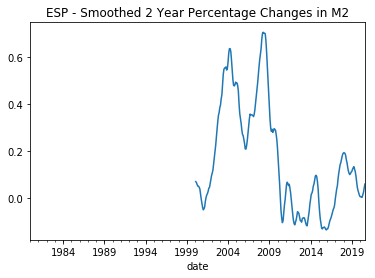

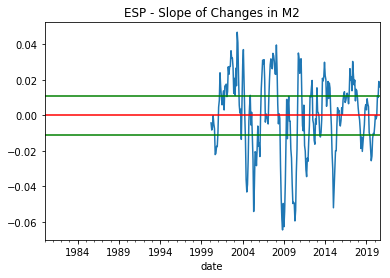

In [436]:
country = "ESP"
change_m2 = m2.pct_change(24)
change_m2[country].plot()
plt.title(country + " - 2 Year Percentage Changes in M2")
plt.show()

# change_m2_12 = m2.pct_change(12)
# change_m2_12[country].plot()
# plt.title(country + " - 1 Year Percentage Changes in M2")
# plt.show()
# creates a lot more volatility around changes in M2

fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
ax1_label = 'Percentage Changes in M2'
ax1.plot(change_m2[country].loc['1989-01-01':'2000-01-01'].to_timestamp(), label = ax1_label)
ax1.set_ylabel(ax1_label)
ax1.legend()
ax2_label = '10 Year Bond Yields'
ax2.plot(LongRates[country].loc['1989-01-01':'2000-01-01'].to_timestamp(), color = 'tab:red', label = ax2_label)
ax2.set_ylabel(ax2_label)
ax2.legend(loc = "lower left")
plt.title(country + " - Percentage Changes in M2 vs. Bond Yields")
plt.show()

print("At 1990, the money supply is technically growing but we see that interest rates are falling. The relationship doesn't quite appear to be whether or not the money supply is growing. It's more a matter of how FAST the money supply is growing. ** Refinement: So, instead of looking at percentage changes in M2, let's look at an estimate for the acceleration of M2 (are the changes in money supply speeding up or slowing down?).\n \n")

print("In order to calculate diffs, we should smooth the curve to remove some of the noise.")
smoothed_change_m2 = change_m2.rolling(6).mean()
smoothed_change_m2[country].plot()
plt.title(country + " - Smoothed 2 Year Percentage Changes in M2")
plt.show()

slope_smoothed_change_m2 = smoothed_change_m2.diff()
country_plot = slope_smoothed_change_m2[country]
country_plot.plot()
std = country_plot.std()
plt.axhline(y= 0.5 * std, color='g', linestyle='-')
plt.axhline(y=-0.5 * std, color='g', linestyle='-')
plt.axhline(y=0, color='r', linestyle='-')
plt.title(country + " - Slope of Changes in M2")
plt.show()

#### Connecting M2 with Bond Yields

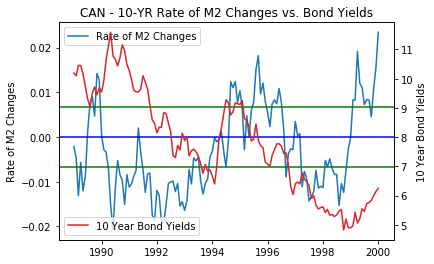

In [372]:
country = "CAN"
std = slope_smoothed_change_m2[country].std()
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
ax1_label = 'Rate of M2 Changes'
ax1.plot(slope_smoothed_change_m2[country].loc['1989-01-01':'2000-01-01'].to_timestamp(), label = ax1_label)
ax1.set_ylabel(ax1_label)
ax1.legend()
ax2_label = '10 Year Bond Yields'
ax2.plot(LongRates[country].loc['1989-01-01':'2000-01-01'].to_timestamp(), color = 'tab:red', label = ax2_label)
ax2.set_ylabel(ax2_label)
ax2.legend(loc = "lower left")
plt.title(country + " - 10-YR Rate of M2 Changes vs. Bond Yields")
ax1.axhline(y= 0.5 * std, color='g', linestyle='-')
ax1.axhline(y=-0.5 * std, color='g', linestyle='-')
ax1.axhline(y=0, color='b', linestyle='-')
plt.show()

#### Data processing
When slope > volatility buffer, expect yields to increase, so short bonds. When slope < volatility buffer, expect yields to decrease, so long bonds. When slope within buffer, hold position.

To produce global views, for each country, compute the # of std. deviations by which the slope differs from 0. Compute a z-score for each country among the global dataset. 

## Signal - Bond Premium and Curve Height

#### Preliminary Observations

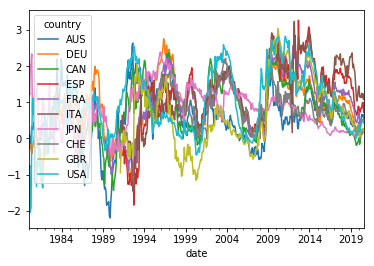

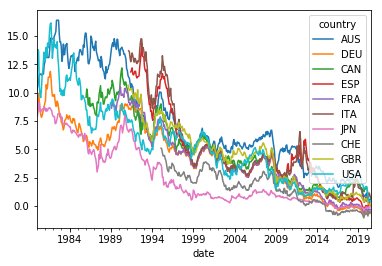

In [99]:
bond_premium = LongRates - ShortRates
bond_premium.plot()
plt.show()

curve_height = (LongRates + ShortRates) * 0.5
curve_height.plot()
plt.show()

global_curve_height = curve_height.mean(axis=1)

#### Does a large diff b/w long and short rates --> a drop in bond yields?

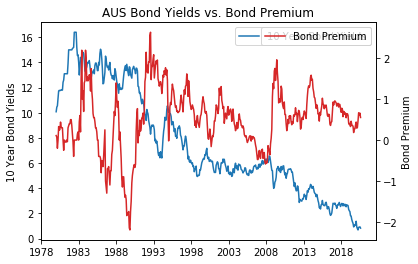

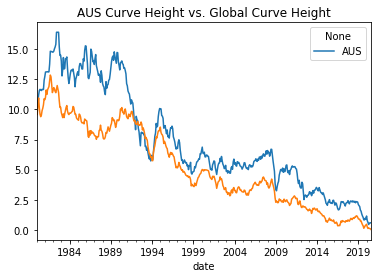

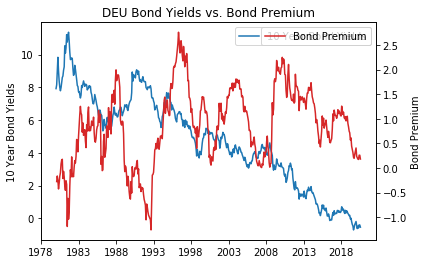

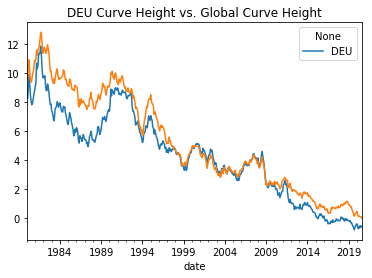

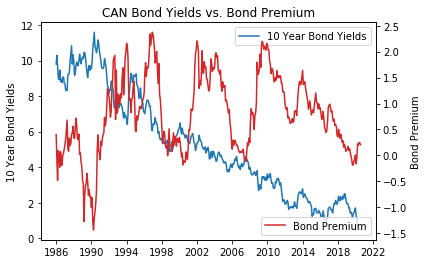

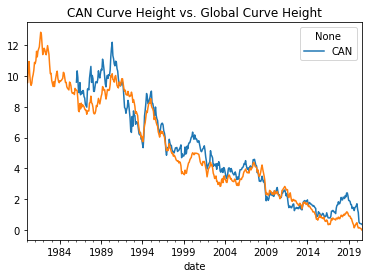

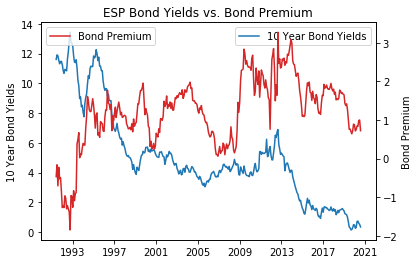

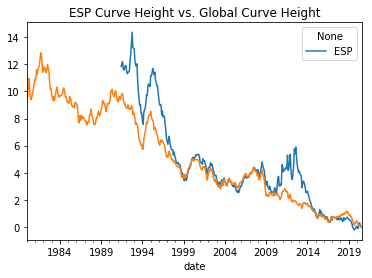

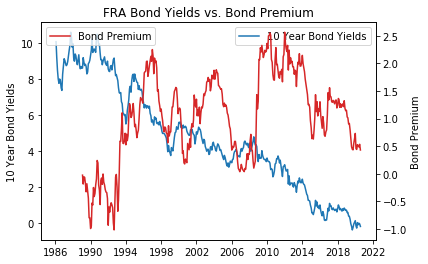

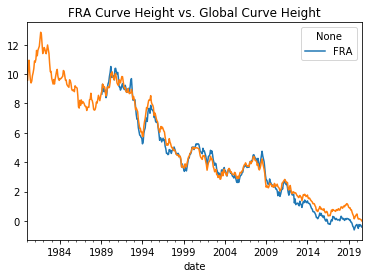

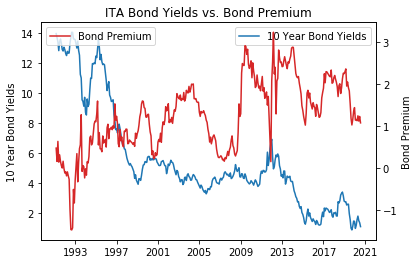

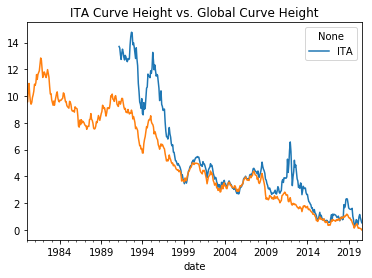

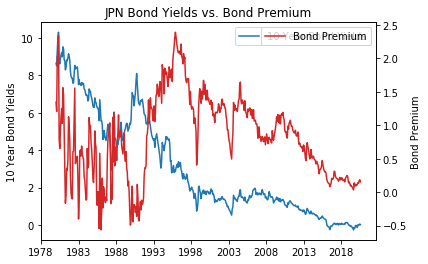

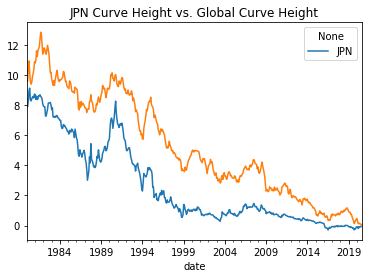

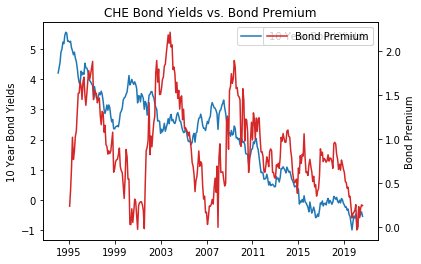

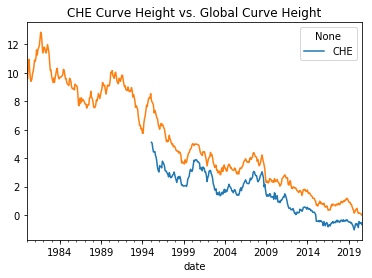

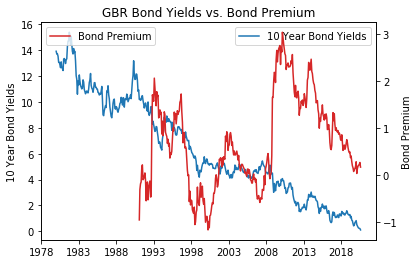

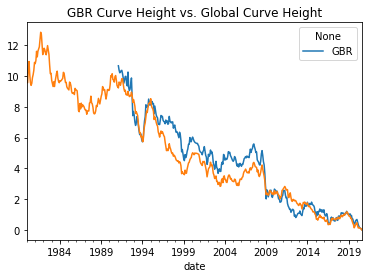

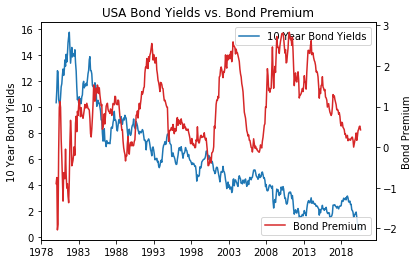

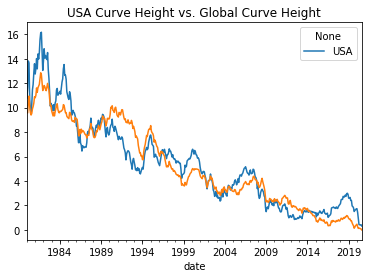

In [375]:
for country in LongRates.columns:
    #Bond Premium
    fig, ax1 = plt.subplots()
    ax2 = ax1.twinx()
    ax1_label = '10 Year Bond Yields'
    ax1.plot(LongRates[country].to_timestamp(), label = ax1_label)
    ax1.set_ylabel(ax1_label)
    ax1.legend()
    ax2_label = 'Bond Premium'
    ax2.plot(bond_premium[country].to_timestamp(), color = 'tab:red', label = ax2_label)
    ax2.set_ylabel(ax2_label)
    ax2.legend()
    plt.title(country + " Bond Yields vs. Bond Premium")
    plt.show()

    #Curve Height 
    curve_height[country].to_timestamp().plot()
    plt.legend()
    global_curve_height.to_timestamp().plot()
    plt.title(country + " Curve Height vs. Global Curve Height")
    plt.show()


#### Takeaway 1: Even if curve height < global average curve height && bond premiums are high, we may still see drops in the 10-yr bond yield. 

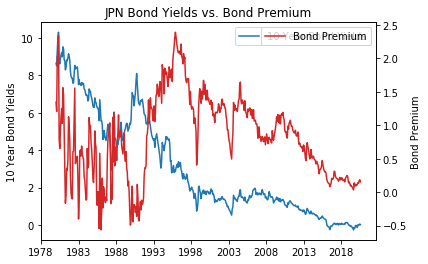

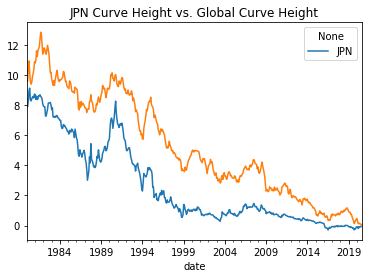

In [374]:
country = "JPN"
#Bond Premium
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
ax1_label = '10 Year Bond Yields'
ax1.plot(LongRates[country].to_timestamp(), label = ax1_label)
ax1.set_ylabel(ax1_label)
ax1.legend()
ax2_label = 'Bond Premium'
ax2.plot(bond_premium[country].to_timestamp(), color = 'tab:red', label = ax2_label)
ax2.set_ylabel(ax2_label)
ax2.legend()
plt.title(country + " Bond Yields vs. Bond Premium")
plt.show()

#Curve Height 
curve_height[country].to_timestamp().plot()
plt.legend()
global_curve_height.to_timestamp().plot()
plt.title(country + " Curve Height vs. Global Curve Height")
plt.show()

#### Takeaway 2: If Curve Height >> Global average curve height && bond premiums are high, we might be more likely to see drops in the bond yields. 

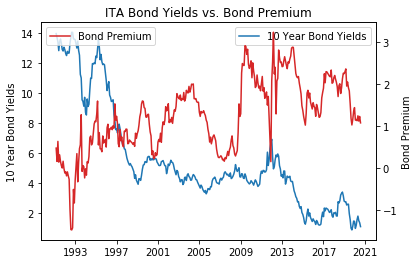

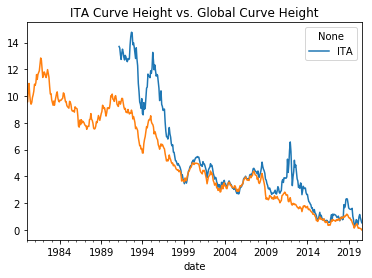

In [376]:
country = "ITA"
#Bond Premium
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
ax1_label = '10 Year Bond Yields'
ax1.plot(LongRates[country].to_timestamp(), label = ax1_label)
ax1.set_ylabel(ax1_label)
ax1.legend()
ax2_label = 'Bond Premium'
ax2.plot(bond_premium[country].to_timestamp(), color = 'tab:red', label = ax2_label)
ax2.set_ylabel(ax2_label)
ax2.legend()
plt.title(country + " Bond Yields vs. Bond Premium")
plt.show()

#Curve Height 
curve_height[country].to_timestamp().plot()
plt.legend()
global_curve_height.to_timestamp().plot()
plt.title(country + " Curve Height vs. Global Curve Height")
plt.show()

##### Data Processing
1. Get a sense for how steep bond premium is in each country
- Normalize bond premium relative to the last 10 years of data (z-scores) larger z-score --> steeper yield curve
2. Combine cross-country data through curve heights.
- Curve height/ max_countries(curve height)
- Considered using z-scores but when weighting the bond premiums, I don't want to negate bond premiums regardless of curve height.
    - **Goal**: promote higher curve heights
3. Weight the normalized bond premiums by the curve height weights

In [426]:
def rolling_z_score(data, window, min_periods):
    rolling = data.rolling(window, min_periods)
    mean = rolling.mean()
    std = rolling.std()
    return (data - mean)/std

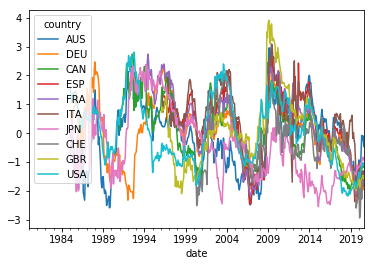

In [152]:
normalized_bond_premium = rolling_z_score(bond_premium, 12*10, 12*5)
normalized_bond_premium.plot()
plt.show()

In [122]:
max_curve_height = curve_height.max(axis = 1)
w_curve_height = curve_height.mul(1/max_curve_height, axis = 0)
w_curve_height.head()

country,AUS,DEU,CAN,ESP,FRA,ITA,JPN,CHE,GBR,USA
date,,,,,,,,,,
1980-01,0.929963,NaN,NaN,NaN,NaN,NaN,0.739100,NaN,NaN,1.000000
1980-02,0.892842,0.710502,NaN,NaN,NaN,NaN,0.677025,NaN,NaN,1.000000
1980-03,0.771180,0.654707,NaN,NaN,NaN,NaN,0.601557,NaN,NaN,1.000000
1980-04,0.821114,0.730022,NaN,NaN,NaN,NaN,0.658358,NaN,NaN,1.000000
1980-05,1.000000,0.795763,NaN,NaN,NaN,NaN,0.789451,NaN,NaN,0.919585


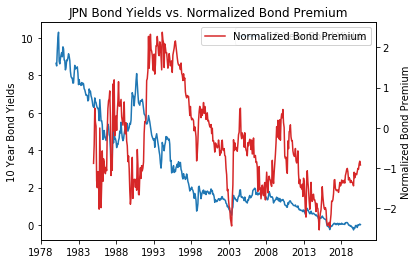

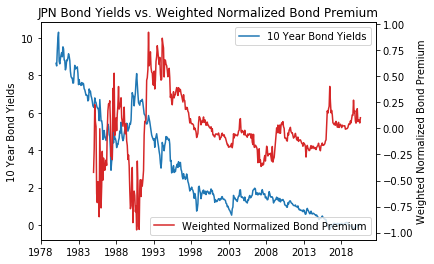

In [124]:
weighted_normalized_bond_premium = normalized_bond_premium * w_curve_height

country = "JPN"
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
ax1_label = '10 Year Bond Yields'
ax1.plot(LongRates[country].to_timestamp(), label = ax1_label)
ax1.set_ylabel(ax1_label)
ax1.legend()
ax2_label = 'Normalized Bond Premium'
ax2.plot(normalized_bond_premium[country].to_timestamp(), color = 'tab:red', label = ax2_label)
ax2.set_ylabel(ax2_label)
ax2.legend()
plt.title(country + " Bond Yields vs. Normalized Bond Premium")
plt.show()

fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
ax1_label = '10 Year Bond Yields'
ax1.plot(LongRates[country].to_timestamp(), label = ax1_label)
ax1.set_ylabel(ax1_label)
ax1.legend()
ax2_label = 'Weighted Normalized Bond Premium'
ax2.plot(weighted_normalized_bond_premium[country].to_timestamp(), color = 'tab:red', label = ax2_label)
ax2.set_ylabel(ax2_label)
ax2.legend()
plt.title(country + " Bond Yields vs. Weighted Normalized Bond Premium")
plt.show()

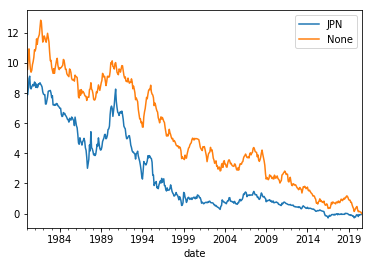

In [128]:
curve_height["JPN"].plot()
global_curve_height.plot()
plt.legend()
plt.show()

##### Potential Refinement
- If bond premiums are negative (yield curve inverts), this shows investors have a high demand for 10-year maturity bonds over 2-year bonds.
    - **Refinement**: If this is the case, combine with information about GDP and unemployment. Are we starting to see improvements in the economy?
    -If no, then go long bonds, 10-year bond yields will likely drop more.
    -If yes, then short the bonds, since yields will likely rise in the near future. 

## Signal - Relative Stock/Bond Performance
Debated GDP vs. Relative Stock/Bond Performance. Both signals provide a window into the opportunity cost and economic growth.
- GDP's impact goes via the equities & opportunity cost argument. That's probably better measured by equities
- GDP has lag, which this indicator avoids.

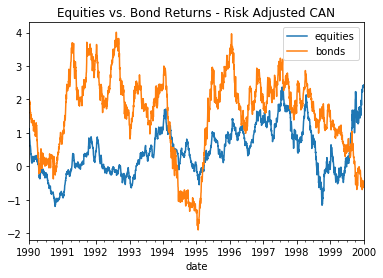

Measuring risk-adjusted returns, because opportunity cost should be about what is the premium being received for the risk being put on.


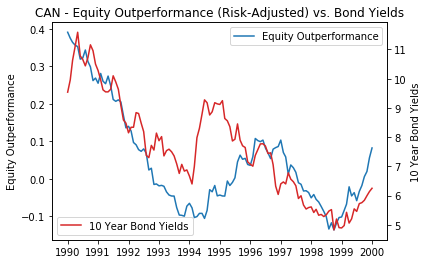

In [433]:
equity_ret = equities.pct_change(WEEKDAYS_IN_YEAR)
equity_risk_adjusted = equity_ret / equity_ret.std()
bond_ret = BondReturnIdx.pct_change(WEEKDAYS_IN_YEAR)
bond_risk_adjusted = bond_ret / bond_ret.std()

country = "CAN"
start_date = '1990-01-01'
end_date = '2000-01-01'
equity_risk_adjusted[country].loc[start_date:end_date].plot(label = "equities")
bond_risk_adjusted[country].loc[start_date:end_date].plot(label = "bonds")
plt.legend()
plt.title("Equities vs. Bond Returns - Risk Adjusted " + country)
plt.show()

print("Measuring risk-adjusted returns, because opportunity cost should be about what is the premium being received for the risk being put on.")

equity_risk_adjusted_outperformance = (equity_risk_adjusted - bond_risk_adjusted)

fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
ax1_label = 'Equity Outperformance'
ax1.plot(change_m2[country].loc[start_date:end_date].to_timestamp(), label = ax1_label)
ax1.set_ylabel(ax1_label)
ax1.legend()
ax2_label = '10 Year Bond Yields'
ax2.plot(LongRates[country].loc[start_date:end_date].to_timestamp(), color = 'tab:red', label = ax2_label)
ax2.set_ylabel(ax2_label)
ax2.legend(loc = "lower left")
plt.title(country + " - Equity Outperformance (Risk-Adjusted) vs. Bond Yields")
plt.show()

#### Data Processing - Normalizing through time
- Rolling Z-score for equity outperformance based on last 5-years
- Higher Z-score, higher we expect bond yields, short those bonds
- Negative Z-score, we expect bond yields to drop, long those bonds

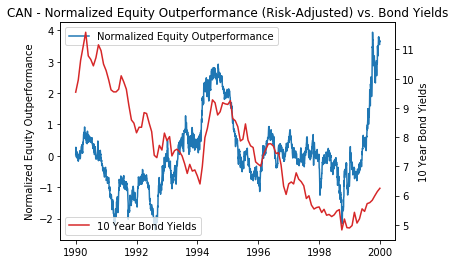

In [435]:
# 5 years, approx the length of short-term debt cycle
z_scores = rolling_z_score(equity_risk_adjusted_outperformance, WEEKDAYS_IN_YEAR * 5, WEEKDAYS_IN_YEAR)

fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
ax1_label = 'Normalized Equity Outperformance'
ax1.plot(z_scores[country].loc[start_date:end_date].loc[start_date:end_date].to_timestamp(), label = ax1_label)
ax1.set_ylabel(ax1_label)
ax1.legend()
ax2_label = '10 Year Bond Yields'
ax2.plot(LongRates[country].loc[start_date:end_date].to_timestamp(), color = 'tab:red', label = ax2_label)
ax2.set_ylabel(ax2_label)
ax2.legend(loc = "lower left")
plt.title(country + " - Normalized Equity Outperformance (Risk-Adjusted) vs. Bond Yields")
plt.show()

#### Data Processing - Cross-Country Comparisons
- Standardize the current z-scores produced for each country (normalize again)
- This will produce information about relative information for how each country is performing in this indicator

## Next Steps
- Figure out how to connect the output of each indicator
    - equal weighting? something like summation from white paper?
    - currently, z-scores from cross-country comparisons do not retain directionality. Would it be better to create these long/short positions at the end?
    
- Apply these indicators to more countries and check how well relationships hold